# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

### Answer to Checkpoint 0

1. **Main limitation of one-hot vectors**: one-hot vectors represent each word as a sparse binary vector with a single 1 and all other positions as 0. the main limitation is that all words are treated as equally different from each other; there's no notion of semantic similarity. for example, "king" and "queen" are just as different as "king" and "banana" because their vectors are orthogonal, which doesn't capture the fact that some words are more related than others.

2. **"meaning emerges from co-occurrence patterns"**: this phrase means that words appearing in similar contexts tend to have similar meanings. if "dog" and "cat" both frequently appear near words like "pet," "animal," "feed," and "walk," we can infer they are semantically related even without explicit definitions. the distributional hypothesis suggests that linguistic items with similar distributions have similar meanings, essentially, you can understand what a word means by looking at the company it keeps.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [ ]:
# Install required libraries (run once)
!pip -q install gensim scikit-learn nltk matplotlib

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [2]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/arad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/arad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [6]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
documents= data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [7]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
2. Name one situation where removing stopwords could be a bad idea.

### Answer to Checkpoint 1

1. **Why we remove stopwords**: we remove stopwords because they're high-frequency function words like "the," "and," "is" that appear in almost every context regardless of topic. since embeddings learn meaning from co-occurrence patterns, stopwords would dominate the context windows but provide little semantic value. removing them helps the model focus on content-bearing words that actually distinguish topics and meanings, making the learned vectors more informative about semantic relationships.

2. **When removing stopwords could be bad**: removing stopwords would be problematic in sentiment analysis tasks where negation matters. phrases like "not good" vs "good" have opposite meanings, but if we remove "not" as a stopword, we lose critical information. similarly, in tasks like authorship attribution, stopwords and function words are actually very informative because they reveal writing style patterns that content words don't capture.

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [8]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1)

print("Vocabulary size:", len(w2v.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [9]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector

print("First 10 values of 'computer' vector:")
print(w2v.wv["computer"][:10])

First 10 values of 'computer' vector:
[ 0.12738737  0.52798736 -0.6004593  -0.00897333  0.10904651 -0.60340965
 -0.19967629  0.58804405  0.44781572 -0.21378344]


### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [10]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "computer"
print(f"Most similar words to '{target}':")

# YOUR CODE HERE - iterate through the results and print each word and score
similar_words = w2v.wv.most_similar(target, topn=10)
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

Most similar words to 'computer':
engineering: 0.7094
networks: 0.6763
isdn: 0.6686
shopper: 0.6647
transmits: 0.6627
bulletin: 0.6576
engineer: 0.6574
programmer: 0.6501
communication: 0.6470
technician: 0.6461


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?
2. Pick 1 surprising neighbor and propose a reason it might appear.

### Answer to Checkpoint 2

1. **Type of similarity**: the neighbors reflect primarily topic similarity, with many tech-related profession words like "engineering," "engineer," "programmer," and "technician" appearing alongside technical terms like "networks," "communication," and "isdn." this shows the model learned that "computer" appears in contexts discussing technology, technical work, and networking. there's also functional similarity since these are nouns that would appear in similar grammatical contexts when discussing technology topics.

2. **Surprising neighbor**: "shopper" appearing with a score of 0.6647 is quite surprising since it's not directly technology-related. this likely appears because the 20 newsgroups dataset includes consumer/shopping discussions about computers where phrases like "computer shopper," product comparisons, or buying guides where "computer" and "shopper" co-occur frequently. this reveals a limitation: embeddings capture distributional patterns in the training data, which may include domain-specific associations that don't reflect general semantic similarity.

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [11]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

# YOUR CODE HERE
positive = ["king", "woman"]
negative = ["man"]
similar_words = w2v.wv.most_similar(positive=positive, negative=negative, topn=5)
print(f"Analogy: {' + '.join(positive)} - {' + '.join(negative)}")
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

Analogy: king + woman - man
rodney: 0.7627
spoken: 0.7416
prince: 0.7396
gerry: 0.7372
omar: 0.7359


### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [12]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

True

In [13]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm

result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
queen_vec = w2v.wv["queen"]

similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.6178


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?
2. Give one reason analogy evaluation might not correlate with task performance.

### Answer to Checkpoint 3

1. **Why analogy results might be wrong even with good embeddings**: analogy results can fail even with good embeddings because they depend on the specific training corpus and context patterns. as we saw with the king-queen example, the 20 newsgroups dataset contains "king" and "queen" primarily in non-royal contexts (rodney king), so the gender relationship isn't encoded in the vectors.

2. **Why analogy evaluation might not correlate with task performance**: analogy tasks are intrinsic evaluations that test whether embeddings capture specific linguistic relationships in isolation, but downstream nlp tasks often require different properties. for example, a sentiment analysis model might perform well even if embeddings fail at gender analogies, because sentiment depends more on words' emotional valence than on analogical reasoning. conversely, embeddings that excel at analogies might still fail at a task if they don't capture the specific semantic distinctions that matter for that application.

---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

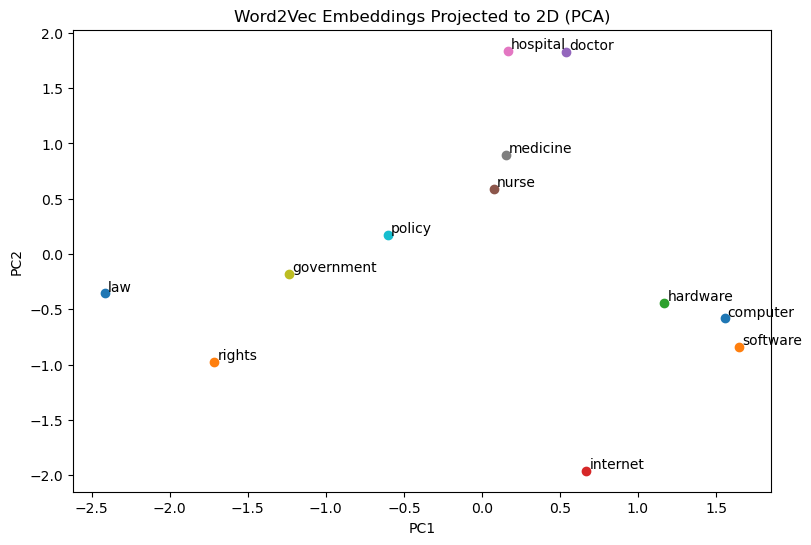

In [14]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = np.array([w2v.wv[w] for w in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?
2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

### Answer to Checkpoint 4

1. **Closest words in the plot**: the health-related words form the tightest cluster, "hospital" and "doctor" are very close together at the top, with "medicine" and "nurse" nearby. on the right side, "computer," "hardware," and "software" form a tech cluster. "government" and "policy" are also relatively close to each other in the center-left area.

2. **Cluster visibility**: yes, there are visible semantic clusters, particularly the health cluster (hospital, doctor, medicine, nurse) in the upper portion and the tech cluster (computer, hardware, software) on the right. however, the clusters aren't perfectly separated, the politics words (government, policy, law, rights) are more scattered. "internet" is surprisingly far from the other tech words, and "law" is isolated on the left. this imperfect clustering happens because some words may co-occur across topics in the newsgroups dataset (e.g., discussions about internet policy or technology law could bridge categories), and with only ~11,000 training documents, there may not be enough data to fully separate all semantic domains.

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [15]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft = FastText(sentences=corpus, vector_size=100, window=5, min_count=5, workers=4)

print("FastText vocabulary size:", len(ft.wv))

FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [16]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)
# YOUR CODE HERE
if query in ft.wv:
    similar_words_ft = ft.wv.most_similar(query, topn=10)
    for word, score in similar_words_ft:
        print(f"{word}: {score:.4f}")
else:
    print(f"FastText does not contain the token '{query}' in its vocabulary.")

# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    # YOUR CODE HERE
    similar_words_w2v = w2v.wv.most_similar(query, topn=10)
    for word, score in similar_words_w2v:
        print(f"{word}: {score:.4f}")
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers
computes: 0.9759
comics: 0.9547
compute: 0.9512
competitors: 0.9478
techniques: 0.9464
compact: 0.9429
netware: 0.9424
subsystems: 0.9386
availability: 0.9351
company: 0.9343

Word2Vec neighbors for: computers
multimedia: 0.8874
platforms: 0.8632
discounts: 0.8580
receivers: 0.8555
idl: 0.8529
sgcs: 0.8521
vista: 0.8502
architecture: 0.8469
isdn: 0.8409
oriented: 0.8408


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [17]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    # YOUR CODE HERE
    # Check if word is in model.wv, if not return None
    # Otherwise return model.wv.most_similar(word, topn=topn)
    if word in model.wv:
        return model.wv.most_similar(word, topn=topn)
    else:
        return None

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  victoria        0.888
  theatre         0.884
  airport         0.882
  melbourne       0.879
  northwest       0.879
  marine          0.873
  alaska          0.872
  headquarters    0.870

Query: space
  shuttle         0.761
  nasa            0.705
  redesign        0.677
  jenks           0.677
  launch          0.668
  exploration     0.668
  goddard         0.660
  missions        0.660

Query: religion
  religions       0.885
  intellectual    0.857
  christianity    0.856
  doctrines       0.851
  mormons         0.843
  islam           0.842
  judaism         0.842
  beings          0.840

Query: graphics
  cad             0.867
  radiosity       0.850
  gems            0.849
  packages        0.843
  workshop        0.835
  silicon         0.834
  assembler       0.831
  iris            0.829


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?
2. What could go wrong if we deploy this directly in production?

### Answer to Checkpoint 5

**Query chosen: "hotel"**

1. **Would these neighbors help a search engine user?**: partially yes, but with significant gaps. neighbors like "victoria," "melbourne," "airport," and "northwest" capture the travel/location context where hotels appear, which could help users find hotel-related content in those locations. however, more semantically relevant terms like "motel," "inn," "accommodation," or "lodging" are missing (motel isn't even in the vocabulary). a user searching for "hotel" would likely want to see related lodging types, not just geographic locations that co-occur with the word. the neighbors reflect topical association rather than true semantic synonyms.

2. **What could go wrong in production?**: several critical issues: (1) **vocabulary coverage** - "motel" isn't in the vocabulary, so the system can't handle synonym expansion for common related terms, (2) **corpus bias** - results reflect the 20 newsgroups dataset (tech, politics, religion), not general-purpose search needs; a model trained on travel content would give very different neighbors, (3) **no query understanding** - the system treats "hotel" as a word in isolation without understanding user intent (booking a hotel vs. learning about hotel construction vs. hotel news), (4) **ranking issues** - similarity scores don't translate directly to search relevance; victoria (0.888) might not be more useful than a lower-scored but semantically closer term, and (5) **scalability** - this approach only works for single words, not phrases or complex queries like "cheap hotels near airport."

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?
2. What is a realistic industry task where word embeddings are useful?
3. When would you choose FastText over Word2Vec?
4. What is one risk or limitation of word embeddings that a practitioner should watch for?

### Answer to Final Reflection

**1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?**

embeddings solve sparsity by representing words as compact lists of numbers (typically 50-300 values) instead of huge vocabulary-sized vectors where almost everything is zero. this dramatically reduces the size and eliminates the wasteful representation where most values don't carry information. more importantly, embeddings solve the "no similarity" problem by learning representations where related words have similar number patterns; words like "computer" and "software" end up close together because they appear in similar contexts during training. in contrast, one-hot vectors treat all words as completely different from each other, so "cat" and "dog" have zero similarity, just like "cat" and "carburetor." embeddings capture meaning through context patterns, following the principle that "you shall know a word by the company it keeps."

**2. What is a realistic industry task where word embeddings are useful?**

a good example is improving search in e-commerce or content platforms. when a user searches for "laptop" on an online store, embeddings can help retrieve products labeled "notebook computer" or "portable pc" even though those exact words weren't in the search. the system measures how similar the search terms are to product descriptions, expanding results beyond exact matches. this is especially valuable for handling synonyms and related terms so if someone searches "running shoes," the system can also show "athletic footwear" or "jogging sneakers" because these terms have similar embeddings.

**3. When would you choose FastText over Word2Vec?**

i would choose fasttext over word2vec when dealing with user-generated content, languages with complex word forms, or specialized domains. fasttext's approach of breaking words into smaller pieces means it can handle words it's never seen before which is crucial for social media where users make typos, use slang, or create new hashtags. for example, with customer reviews, fasttext can generate reasonable representations for misspellings like "amaazing" or "restaraunt" by recognizing the shared letter patterns with "amazing" and "restaurant."

**4. What is one risk or limitation of word embeddings that a practitioner should watch for?**

a major limitation is that embeddings absorb and can amplify biases in the training data, which can lead to unfair outcomes when used in real systems. embeddings learn purely from word patterns so if the training text contains biased language or stereotypes, these get baked into the word vectors. for example, models trained on news articles have shown gender bias where "doctor" relates more to male words and "nurse" to female words, or racial bias in how different groups are associated with positive or negative terms. this becomes dangerous when embeddings are used in important applications like screening resumes, moderating content, or evaluating loan applications. developers need to carefully check their training data, test embeddings for known biases, and consider whether the training text really represents the diverse population who will use the system. just because embeddings show good similarity scores or pass analogy tests doesn't mean they're safe or fair to use in production.

---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** (“meaning from context”).
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive


---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
2. What does the phrase **“meaning emerges from co-occurrence patterns”** mean to you?


---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [2]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups


In [3]:
# Load the dataset
# remove=... strips off headers/footers/quotes to reduce noise
data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.


In [4]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  # isalpha() filters out non-alphabetic tokens
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
2. Name one situation where removing stopwords could be a bad idea.


---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **“You shall know a word by the company it keeps.”** (J. R. Firth)

In practice:
- a word’s **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.


---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.


In [5]:
# Train Word2Vec (Skip-gram)
# workers uses multiple CPU cores to speed up training
w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,   # embedding dimension
    window=5,          # context window
    min_count=5,       # ignore very rare words
    workers=4,
    sg=1               # 1 = Skip-gram, 0 = CBOW
)

print("Vocabulary size:", len(w2v.wv))

Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.


In [6]:
# Inspect the first few values of a word vector
w2v.wv["computer"][:10]

array([-0.13768277,  0.348896  , -0.29491058,  0.2895632 , -0.26643443,
       -0.7159822 , -0.5758598 ,  0.33535   ,  0.40377364, -0.20027319],
      dtype=float32)

### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *“motel”*, we may want to retrieve documents about *“hotel”*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.


In [7]:
# Find most similar words to a target word
target = "computer"
print(f"Most similar words to '{target}':")
for word, score in w2v.wv.most_similar(target, topn=10): # w2v.wv.most_similar returns a list of (word, similarity score) tuples
    print(f"{word:15s}  {score:.3f}")

Most similar words to 'computer':
engineering      0.705
transmits        0.701
dsp              0.690
networks         0.689
communication    0.683
mainframe        0.682
shopper          0.679
architecture     0.671
peripheral       0.670
isdn             0.670


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?
2. Pick 1 surprising neighbor and propose a reason it might appear.


---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [8]:
# Analogy / vector arithmetic
w2v.wv.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=5
)

[('omar', 0.781248152256012),
 ('deposition', 0.7765458226203918),
 ('brothers', 0.7540661692619324),
 ('prince', 0.7531440258026123),
 ('garden', 0.7528167366981506)]

Why "queen" didn't appear:

- Training corpus matters — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- Corpus size — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words (Google News Word2Vec uses 100 billion words).

- Word frequency — "queen" might be rare or absent in your vocabulary. You can check:

- Context diversity — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts (e.g., "The king ruled..." vs "The queen ruled..."). Newsgroup posts likely don't have enough such examples.

In [10]:
"queen" in w2v.wv  # Returns True/False

True

Even though "queen" is in the vocabulary, it didn't appear because the resulting vector is closer to other words.

The math behind what happened
When you compute:

$$\vec{result}  \approx = \vec{king}  - \vec{man} + \vec{woman}$$

The most_similar() function then finds words with the highest cosine similarity to this result vector. The 5 words returned ("omar", "deposition", "brothers", "prince", "garden") all have higher cosine similarity to the result vector than "queen" does.

Why "queen" has lower similarity
Context determines meaning — In the 20 Newsgroups corpus, "king" might appear in contexts like:

Rodney King (news about LA riots)
Martin Luther King Jr. (civil rights discussions)
Stephen King (book discussions)
Chess discussions ("the king is in check")
These contexts have nothing to do with royalty or gender relationships.

"queen" might have different contexts — "queen" might appear in contexts like:

Queen (the band)
Drag queen discussions
Chess terminology
No parallel structure — For the analogy to work, you need many sentences like:

"The king sat on his throne" ↔ "The queen sat on her throne"
"The king ruled the kingdom" ↔ "The queen ruled the kingdom"
The 20 Newsgroups corpus simply doesn't have enough of these parallel examples.

In [13]:
# Check the actual similarity score for "queen"
import numpy as np
from numpy.linalg import norm

result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
queen_vec = w2v.wv["queen"]

similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.6653


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are “good”?
2. Give one reason analogy evaluation might not correlate with task performance.


---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.


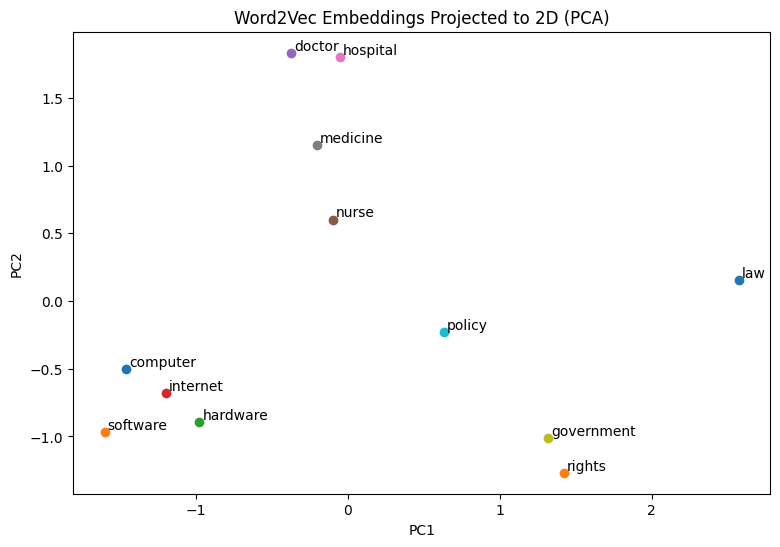

In [9]:
# Choose words to visualize (feel free to edit this list)
words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

vectors = np.array([w2v.wv[w] for w in words])

# PCA to 2D
pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?
2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?


---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology


In [14]:
# Train FastText on the same corpus
ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

print("FastText vocabulary size:", len(ft.wv))

FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.


In [15]:
# Compare similarity results for a variant form
query = "computers"

print("FastText neighbors for:", query)
for word, score in ft.wv.most_similar(query, topn=10):
    print(f"{word:15s}  {score:.3f}")

# Word2Vec may or may not have this token depending on min_count and preprocessing
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    for word, score in w2v.wv.most_similar(query, topn=10):
        print(f"{word:15s}  {score:.3f}")
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary (likely filtered by min_count).")

FastText neighbors for: computers
computes         0.972
comics           0.969
compact          0.964
compute          0.961
competitors      0.952
compete          0.946
techniques       0.941
compuadd         0.938
items            0.937
voices           0.937

Word2Vec neighbors for: computers
multimedia       0.898
receivers        0.863
sgcs             0.859
vista            0.858
discounts        0.858
peripheral       0.857
platforms        0.852
xservers         0.852
gis              0.850
workplace        0.849


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny “semantic search” demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.


In [16]:
def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    if word not in model.wv:
        return None
    return model.wv.most_similar(word, topn=topn)

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  theatre         0.877
  airport         0.877
  melbourne       0.876
  huntington      0.874
  nationwide      0.873
  victoria        0.870
  spacecause      0.870
  pacific         0.868

Query: space
  shuttle         0.761
  nasa            0.728
  station         0.684
  redesign        0.681
  launch          0.670
  goddard         0.666
  jenks           0.666
  exploration     0.666

Query: religion
  religions       0.867
  judaism         0.859
  beings          0.846
  mormons         0.843
  intellectual    0.840
  christianity    0.840
  doctrines       0.837
  religious       0.835

Query: graphics
  cad             0.838
  gems            0.835
  animation       0.828
  radiosity       0.828
  silicon         0.813
  workshop        0.810
  editing         0.805
  multimedia      0.801


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?
2. What could go wrong if we deploy this directly in production?


---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.


---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and “no similarity” issues of one-hot vectors?
2. What is a realistic industry task where word embeddings are useful?
3. When would you choose FastText over Word2Vec?
4. What is one risk or limitation of word embeddings that a practitioner should watch for?


---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.
